In [1]:
import numpy as np
import matplotlib.pyplot as plt


def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D


def calc_prob_matrix(distances, sigmas, zero_index=None):
    """Convert a distances matrix to a matrix of probabilities."""
    two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1))) #makes the sigmas array from (num_points, ) to (num_points,1) for ease of calculations later
    X = distances/two_sig_sq
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probailities to be 0.
    if zero_index is None:
        np.fill_diagonal(e_x, 0.)
    else:
        e_x[:, zero_index] = 0.

    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])





def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.

    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    
    return guess


def calc_perplexity(prob_matrix):
    """Calculate the perplexity of each row
    of a matrix of probabilities."""
    # print("from perplexity fucntion for first point: \n",prob_matrix)
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas, zero_index):
    """Wrapper function for quick calculation of
    perplexity over a distance matrix."""
    return calc_perplexity(
        calc_prob_matrix(distances, sigmas, zero_index))


def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda temp_sigma: \
            perplexity(distances[i:i+1, :], np.array(temp_sigma), i)
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)



def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances), inv_distances


def tsne_grad(P, Q, Y, distances):
    """t-SNE: Estimate the gradient of the cost with respect to Y."""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  # NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # NxNx2
    # Expand our distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(distances, 2)  # NxNx1
    # Weight this (NxNx2) by distances matrix (NxNx1)
    y_diffs_wt = y_diffs * distances_expanded  # NxNx2
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)  # Nx2
    return grad


def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    # this below expression is equivalent to for all i,j: pij = (pi|j + pj|i) /2
    P = (p_conditional + p_conditional.T) / (2. * p_conditional.shape[0])
    return P


def estimate_sne(X, P, rng, num_iters, learning_rate,
                 momentum):
    
    """
    # Arguments
        X: Input data matrix.
        y: Class labels for that matrix.
        P: Matrix of joint probabilities.
        rng: np.random.RandomState().
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        plot: How many times to plot during training.
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our 2D representation
    # Y = rng.normal(0., 0.0001, [X.shape[0], 2])
    np.random.seed(0)
    Y = X.dot(np.random.rand(X.shape[1],2))

    # Initialise past values (used for momentum)
    Y_m2 = Y.copy()
    Y_m1 = Y.copy()

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_tsne(Y)
        # Estimate gradients with respect to Y
        grads = tsne_grad(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
        Y += momentum * (Y_m1 - Y_m2)
        Y_m2 = Y_m1.copy()
        Y_m1 = Y.copy()


    return Y

In [2]:
PERPLEXITY = 50
SEED = 1                    # Random seed
MOMENTUM = 0.9
LEARNING_RATE = 10.
EPOCHS = 500             # Num iterations to train for


# numpy RandomState for reproducibility
rng = np.random.RandomState(SEED)
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
digits = load_digits()
print([i for i in digits.target])
digits.target.shape

new_X = digits.data
train_y =digits.target

sc = StandardScaler()


# new_X = new_X[:200]
new_X_train = sc.fit_transform(new_X)
pca = PCA(n_components = 30)
new_X_train = pca.fit_transform(new_X_train)
P = p_joint(new_X_train, PERPLEXITY)


final_X = estimate_sne(new_X_train, P, rng, EPOCHS, LEARNING_RATE, MOMENTUM)
# print(final_X)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 

In [3]:
# import seaborn as sns
# import pandas as pd
# # print(Y)
# df = pd.DataFrame()
# x = [i[0] for i in final_X]
# y = [i[1] for i in final_X]
# df["feat-1"] = x
# df["feat-2"] = y
# cat=[]
# for i in train_y[:200]:
#   cat.append(i)
# # df["y"] = cat

# sns.scatterplot(x="feat-1", y="feat-2", hue=cat,
#                 palette=sns.color_palette("hls", 10),
#                 data=df).set(title="UCI digits graph") 

import seaborn as sns
import pandas as pd
# print(Y)
df = pd.DataFrame()
excl=[]
for i in range(len(list(final_X))):
  if(final_X[i][0]>10 or final_X[i][1]>10):
    # print(i)
    excl.append(i)

print(len(excl))

x = [final_X[i][0] for i in range(len(list(final_X))) if i not in excl]
y = [final_X[i][1] for i in range(len(list(final_X))) if i not in excl]
df["feat-1"] = x
df["feat-2"] = y
cat=[]
for i in range(len(train_y)):
  if i not in excl:
    cat.append(train_y[i])
# df["y"] = cat



1


[Text(0.5, 1.0, 'Scratch t-SNE Visualization')]

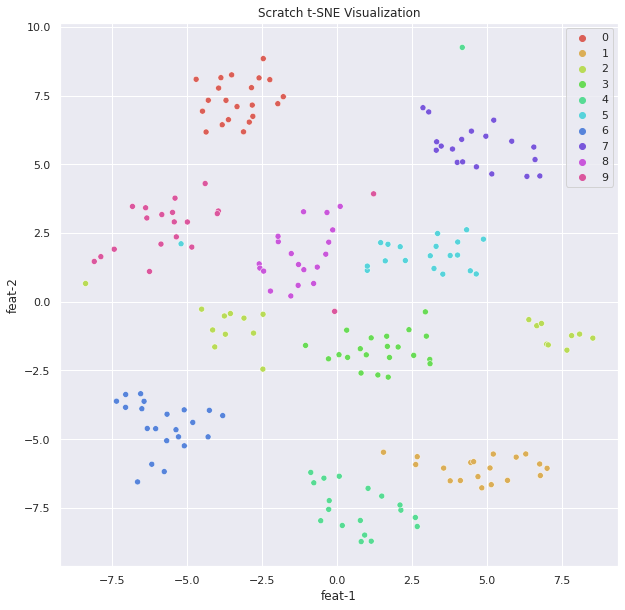

In [4]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x="feat-1", y="feat-2", hue=cat,
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Scratch t-SNE Visualization")